<a href="https://colab.research.google.com/github/vassilybar/cs231n_solutions_colab/blob/master/assignment_2/Dropout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dropout
Dropout [1] is a technique for regularizing neural networks by randomly setting some features to zero during the forward pass. In this exercise you will implement a dropout layer and modify your fully-connected network to optionally use dropout.

[1] [Geoffrey E. Hinton et al, "Improving neural networks by preventing co-adaptation of feature detectors", arXiv 2012](https://arxiv.org/abs/1207.0580)

In [2]:
!rm -rf * && \
 wget 'http://cs231n.github.io/assignments/2018/spring1718_assignment2.zip' && \
 unzip 'spring1718_assignment2.zip' && \
 mv assignment2/cs231n . && \
 pushd cs231n/datasets && \
 chmod +x ./get_datasets.sh && \
 ./get_datasets.sh && \
 popd && \
 rm -rf assignment2

--2019-02-06 18:17:59--  http://cs231n.github.io/assignments/2018/spring1718_assignment2.zip
Resolving cs231n.github.io (cs231n.github.io)... 185.199.110.153, 185.199.109.153, 185.199.108.153, ...
Connecting to cs231n.github.io (cs231n.github.io)|185.199.110.153|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 116579 (114K) [application/zip]
Saving to: ‘spring1718_assignment2.zip’

spring1718_assignme 100%[===================>] 113.85K  --.-KB/s    in 0.04s   

2019-02-06 18:17:59 (3.02 MB/s) - ‘spring1718_assignment2.zip’ saved [116579/116579]

Archive:  spring1718_assignment2.zip
   creating: assignment2/
 extracting: assignment2/.gitignore  
  inflating: assignment2/BatchNormalization.ipynb  
  inflating: assignment2/collectSubmission.sh  
  inflating: assignment2/ConvolutionalNetworks.ipynb  
   creating: assignment2/cs231n/
  inflating: assignment2/cs231n/.gitignore  
 extracting: assignment2/cs231n/__init__.py  
   creating: assignment2/cs231n/classifiers/

In [7]:
# As usual, a bit of setup
from __future__ import print_function
import time
import numpy as np
import matplotlib.pyplot as plt
#from cs231n.classifiers.fc_net import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
#from cs231n.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in data.items():
  print('%s: ' % k, v.shape)

X_train:  (49000, 3, 32, 32)
y_train:  (49000,)
X_val:  (1000, 3, 32, 32)
y_val:  (1000,)
X_test:  (1000, 3, 32, 32)
y_test:  (1000,)


# Dropout forward pass
In the file `cs231n/layers.py`, implement the forward pass for dropout. Since dropout behaves differently during training and testing, make sure to implement the operation for both modes.

Once you have done so, run the cell below to test your implementation.

In [0]:
def affine_forward(x, w, b):
    """
    Computes the forward pass for an affine (fully-connected) layer.

    The input x has shape (N, d_1, ..., d_k) and contains a minibatch of N
    examples, where each example x[i] has shape (d_1, ..., d_k). We will
    reshape each input into a vector of dimension D = d_1 * ... * d_k, and
    then transform it to an output vector of dimension M.

    Inputs:
    - x: A numpy array containing input data, of shape (N, d_1, ..., d_k)
    - w: A numpy array of weights, of shape (D, M)
    - b: A numpy array of biases, of shape (M,)

    Returns a tuple of:
    - out: output, of shape (N, M)
    - cache: (x, w, b)
    """
    out = None
    N = x.shape[0]
    out = x.reshape(N, -1).dot(w) + b
    cache = (x, w, b)
    
    return out, cache


def affine_backward(dout, cache):
    """
    Computes the backward pass for an affine layer.

    Inputs:
    - dout: Upstream derivative, of shape (N, M)
    - cache: Tuple of:
      - x: Input data, of shape (N, d_1, ... d_k)
      - w: Weights, of shape (D, M)
      - b: Biases, of shape (M,)

    Returns a tuple of:
    - dx: Gradient with respect to x, of shape (N, d1, ..., d_k)
    - dw: Gradient with respect to w, of shape (D, M)
    - db: Gradient with respect to b, of shape (M,)
    """
    x, w, b = cache
    dx, dw, db = None, None, None
    
    dx = dout.dot(w.T).reshape(x.shape)
    dw = x.reshape(x.shape[0], -1).T.dot(dout)
    db = np.sum(dout, axis=0)
    
    return dx, dw, db


def relu_forward(x):
    """
    Computes the forward pass for a layer of rectified linear units (ReLUs).

    Input:
    - x: Inputs, of any shape

    Returns a tuple of:
    - out: Output, of the same shape as x
    - cache: x
    """
    out = None
    
    out = np.maximum(0, x)
    cache = x
    
    return out, cache


def relu_backward(dout, cache):
    """
    Computes the backward pass for a layer of rectified linear units (ReLUs).

    Input:
    - dout: Upstream derivatives, of any shape
    - cache: Input x, of same shape as dout

    Returns:
    - dx: Gradient with respect to x
    """
    dx, x = None, cache
    
    dx = dout * (x > 0)
    
    return dx


def batchnorm_forward(x, gamma, beta, bn_param):
    """
    Forward pass for batch normalization.

    Input:
    - x: Data of shape (N, D)
    - gamma: Scale parameter of shape (D,)
    - beta: Shift paremeter of shape (D,)
    - bn_param: Dictionary with the following keys:
      - mode: 'train' or 'test'; required
      - eps: Constant for numeric stability
      - momentum: Constant for running mean / variance.
      - running_mean: Array of shape (D,) giving running mean of features
      - running_var Array of shape (D,) giving running variance of features

    Returns a tuple of:
    - out: of shape (N, D)
    - cache: A tuple of values needed in the backward pass
    """
    mode = bn_param['mode']
    eps = bn_param.get('eps', 1e-5)
    momentum = bn_param.get('momentum', 0.9)

    N, D = x.shape
    running_mean = bn_param.get('running_mean', np.zeros(D, dtype=x.dtype))
    running_var = bn_param.get('running_var', np.zeros(D, dtype=x.dtype))

    out, cache = None, None
    if mode == 'train':
        batch_mean = np.mean(x, axis=0)
        batch_var = np.var(x, axis=0)
        xh = (x - batch_mean) / np.sqrt(batch_var + eps)
        out = gamma * xh + beta
        running_mean = momentum * running_mean + (1 - momentum) * batch_mean
        running_var = momentum * running_var + (1 - momentum) * batch_var
        
        cache = (x, xh, gamma, beta, batch_mean, batch_var, eps)
        
    elif mode == 'test':
        x = (x - running_mean) / np.sqrt(running_var + eps)
        out = gamma * x + beta
        
    else:
        raise ValueError('Invalid forward batchnorm mode "%s"' % mode)

    # Store the updated running means back into bn_param
    bn_param['running_mean'] = running_mean
    bn_param['running_var'] = running_var

    return out, cache


def batchnorm_backward(dout, cache):
    """
    Backward pass for batch normalization.
    
    Inputs:
    - dout: Upstream derivatives, of shape (N, D)
    - cache: Variable of intermediates from batchnorm_forward.

    Returns a tuple of:
    - dx: Gradient with respect to inputs x, of shape (N, D)
    - dgamma: Gradient with respect to scale parameter gamma, of shape (D,)
    - dbeta: Gradient with respect to shift parameter beta, of shape (D,)
    """
    dx, dgamma, dbeta = None, None, None
    
    x, xh, gamma, beta, mu, sigma_sq, eps = cache
    m = x.shape[0]
    dgamma = np.sum(dout * xh, axis=0)
    dbeta = np.sum(dout, axis=0)
    dxh = dout * gamma
    dsigma = -0.5 * np.sum(dxh * (x - mu), axis=0) * (sigma_sq + eps)**(-3/2)
    dmu = - np.sum(dxh, axis=0) / np.sqrt(sigma_sq + eps) - \
                2 * dsigma * np.sum(x - mu, axis=0) / m
    dx = dxh / np.sqrt(sigma_sq + eps) + 2 * dsigma * (x - mu) / m + \
                                                    dmu / m
    
    return dx, dgamma, dbeta


def batchnorm_backward_alt(dout, cache):
    """
    Alternative backward pass for batch normalization.
    
    Inputs / outputs: Same as batchnorm_backward
    """
    dx, dgamma, dbeta = None, None, None
    
    x, xh, gamma, beta, mu, sigma_sq, eps = cache
    m = x.shape[0]
    std = np.sqrt(sigma_sq + eps)
    
    dgamma = np.sum(dout * xh, axis=0)
    dbeta = np.sum(dout, axis=0)
    dx = gamma * ((dout - dbeta / m) + dgamma * (np.sum(xh, axis=0) - xh) / m) / std
    
    return dx, dgamma, dbeta


def layernorm_forward(x, gamma, beta, ln_param):
    """
    Forward pass for layer normalization.
    
    Input:
    - x: Data of shape (N, D)
    - gamma: Scale parameter of shape (D,)
    - beta: Shift paremeter of shape (D,)
    - ln_param: Dictionary with the following keys:
        - eps: Constant for numeric stability

    Returns a tuple of:
    - out: of shape (N, D)
    - cache: A tuple of values needed in the backward pass
    """
    out, cache = None, None
    eps = ln_param.get('eps', 1e-5)

    batch_mean = np.mean(x, axis=1).reshape(-1,1)
    batch_var = np.var(x, axis=1).reshape(-1,1)
    xh = (x - batch_mean) / np.sqrt(batch_var + eps)
    out = gamma * xh + beta
    
    cache = (x, xh, gamma, beta, batch_mean, batch_var, eps)
    
    return out, cache


def layernorm_backward(dout, cache):
    """
    Backward pass for layer normalization.

    Inputs:
    - dout: Upstream derivatives, of shape (N, D)
    - cache: Variable of intermediates from layernorm_forward.

    Returns a tuple of:
    - dx: Gradient with respect to inputs x, of shape (N, D)
    - dgamma: Gradient with respect to scale parameter gamma, of shape (D,)
    - dbeta: Gradient with respect to shift parameter beta, of shape (D,)
    """
    dx, dgamma, dbeta = None, None, None
    
    x, xh, gamma, beta, mu, sigma_sq, eps = cache
    m = x.shape[1]
    dgamma = np.sum(dout * xh, axis=0)
    dbeta = np.sum(dout, axis=0)
    std = np.sqrt(sigma_sq + eps)
    dx = ((gamma * dout - np.sum(gamma * dout, axis=1).reshape(-1,1) / m) + \
                  np.sum(gamma * dout * xh, axis=1).reshape(-1,1) * (np.sum(xh, axis=1).reshape(-1,1) - xh) / m) / std
    
    return dx, dgamma, dbeta


def dropout_forward(x, dropout_param):
    """
    Performs the forward pass for (inverted) dropout.

    Inputs:
    - x: Input data, of any shape
    - dropout_param: A dictionary with the following keys:
      - p: Dropout parameter. We keep each neuron output with probability p.
      - mode: 'test' or 'train'. If the mode is train, then perform dropout;
        if the mode is test, then just return the input.
      - seed: Seed for the random number generator. Passing seed makes this
        function deterministic, which is needed for gradient checking but not
        in real networks.

    Outputs:
    - out: Array of the same shape as x.
    - cache: tuple (dropout_param, mask). In training mode, mask is the dropout
      mask that was used to multiply the input; in test mode, mask is None.

    NOTE: Please implement **inverted** dropout, not the vanilla version of dropout.
    See http://cs231n.github.io/neural-networks-2/#reg for more details.

    NOTE 2: Keep in mind that p is the probability of **keep** a neuron
    output; this might be contrary to some sources, where it is referred to
    as the probability of dropping a neuron output.
    """
    p, mode = dropout_param['p'], dropout_param['mode']
    if 'seed' in dropout_param:
        np.random.seed(dropout_param['seed'])

    mask = None
    out = None

    if mode == 'train':
        #######################################################################
        # TODO: Implement training phase forward pass for inverted dropout.   #
        # Store the dropout mask in the mask variable.                        #
        #######################################################################
        
        mask = np.random.rand(*x.shape)
        mask = (mask < p) / p
        out = x * mask 
        #######################################################################
        #                           END OF YOUR CODE                          #
        #######################################################################
    elif mode == 'test':
        #######################################################################
        # TODO: Implement the test phase forward pass for inverted dropout.   #
        #######################################################################
        
        out = x
        
        #######################################################################
        #                            END OF YOUR CODE                         #
        #######################################################################

    cache = (dropout_param, mask)
    out = out.astype(x.dtype, copy=False)

    return out, cache


def dropout_backward(dout, cache):
    """
    Perform the backward pass for (inverted) dropout.

    Inputs:
    - dout: Upstream derivatives, of any shape
    - cache: (dropout_param, mask) from dropout_forward.
    """
    dropout_param, mask = cache
    mode = dropout_param['mode']

    dx = None
    if mode == 'train':
        #######################################################################
        # TODO: Implement training phase backward pass for inverted dropout   #
        #######################################################################
        
        dx = dout * mask
        
        #######################################################################
        #                          END OF YOUR CODE                           #
        #######################################################################
    elif mode == 'test':
        dx = dout
    return dx


def softmax_loss(x, y):
    """
    Computes the loss and gradient for softmax classification.

    Inputs:
    - x: Input data, of shape (N, C) where x[i, j] is the score for the jth
      class for the ith input.
    - y: Vector of labels, of shape (N,) where y[i] is the label for x[i] and
      0 <= y[i] < C

    Returns a tuple of:
    - loss: Scalar giving the loss
    - dx: Gradient of the loss with respect to x
    """
    shifted_logits = x - np.max(x, axis=1, keepdims=True)
    Z = np.sum(np.exp(shifted_logits), axis=1, keepdims=True)
    log_probs = shifted_logits - np.log(Z)
    probs = np.exp(log_probs)
    N = x.shape[0]
    loss = -np.sum(log_probs[np.arange(N), y]) / N
    dx = probs.copy()
    dx[np.arange(N), y] -= 1
    dx /= N
    return loss, dx

In [24]:
np.random.seed(231)
x = np.random.randn(500, 500) + 10

for p in [0.25, 0.4, 0.7]:
  out, _ = dropout_forward(x, {'mode': 'train', 'p': p})
  out_test, _ = dropout_forward(x, {'mode': 'test', 'p': p})

  print('Running tests with p = ', p)
  print('Mean of input: ', x.mean())
  print('Mean of train-time output: ', out.mean())
  print('Mean of test-time output: ', out_test.mean())
  print('Fraction of train-time output set to zero: ', (out == 0).mean())
  print('Fraction of test-time output set to zero: ', (out_test == 0).mean())
  print()

Running tests with p =  0.25
Mean of input:  10.000207878477502
Mean of train-time output:  10.014059116977283
Mean of test-time output:  10.000207878477502
Fraction of train-time output set to zero:  0.749784
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.4
Mean of input:  10.000207878477502
Mean of train-time output:  9.977917658761159
Mean of test-time output:  10.000207878477502
Fraction of train-time output set to zero:  0.600796
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.7
Mean of input:  10.000207878477502
Mean of train-time output:  9.987811912159426
Mean of test-time output:  10.000207878477502
Fraction of train-time output set to zero:  0.30074
Fraction of test-time output set to zero:  0.0



# Dropout backward pass
In the file `cs231n/layers.py`, implement the backward pass for dropout. After doing so, run the following cell to numerically gradient-check your implementation.

In [25]:
np.random.seed(231)
x = np.random.randn(10, 10) + 10
dout = np.random.randn(*x.shape)

dropout_param = {'mode': 'train', 'p': 0.2, 'seed': 123}
out, cache = dropout_forward(x, dropout_param)
dx = dropout_backward(dout, cache)
dx_num = eval_numerical_gradient_array(lambda xx: dropout_forward(xx, dropout_param)[0], x, dout)

# Error should be around e-10 or less
print('dx relative error: ', rel_error(dx, dx_num))

dx relative error:  5.44560814873387e-11


## Inline Question 1:
What happens if we do not divide the values being passed through inverse dropout by `p` in the dropout layer? Why does that happen?

# Fully-connected nets with Dropout
In the file `cs231n/classifiers/fc_net.py`, modify your implementation to use dropout. Specifically, if the constructor of the net receives a value that is not 1 for the `dropout` parameter, then the net should add dropout immediately after every ReLU nonlinearity. After doing so, run the following to numerically gradient-check your implementation.

In [26]:
%%writefile optim.py

import numpy as np

def sgd(w, dw, config=None):
    if config is None: config = {}
    config.setdefault('learning_rate', 1e-2)

    w -= config['learning_rate'] * dw
    return w, config


def adam(w, dw, config=None):
    if config is None: config = {}
    learning_rate = config.setdefault('learning_rate', 1e-3)
    beta1 = config.setdefault('beta1', 0.9)
    beta2 = config.setdefault('beta2', 0.999)
    eps = config.setdefault('epsilon', 1e-8)
    config.setdefault('m', np.zeros_like(w))
    config.setdefault('v', np.zeros_like(w))
    t = config.setdefault('t', 0)

    next_w = None
    
    t += 1
    # t is your iteration counter going from 1 to infinity
    config['m'] = beta1 * config['m'] + (1 - beta1) * dw
    mt = config['m'] / (1 - beta1 ** t)
    config['v'] = beta2 * config['v'] + (1 - beta2) * (dw ** 2)
    vt = config['v'] / (1 - beta2 ** t)
    next_w = w - learning_rate * mt / (np.sqrt(vt) + eps)

    return next_w, config

Writing optim.py


In [0]:
from __future__ import print_function, division
from future import standard_library
standard_library.install_aliases()
from builtins import range
from builtins import object
import os
import pickle as pickle

import optim

class Solver(object):
    
    def __init__(self, model, data, **kwargs):
        """
        Construct a new Solver instance.
        """
        self.model = model
        self.X_train = data['X_train']
        self.y_train = data['y_train']
        self.X_val = data['X_val']
        self.y_val = data['y_val']

        # Unpack keyword arguments
        self.update_rule = kwargs.pop('update_rule', 'sgd')
        self.optim_config = kwargs.pop('optim_config', {})
        self.lr_decay = kwargs.pop('lr_decay', 1.0)
        self.batch_size = kwargs.pop('batch_size', 100)
        self.num_epochs = kwargs.pop('num_epochs', 10)
        self.num_train_samples = kwargs.pop('num_train_samples', 1000)
        self.num_val_samples = kwargs.pop('num_val_samples', None)

        self.checkpoint_name = kwargs.pop('checkpoint_name', None)
        self.print_every = kwargs.pop('print_every', 10)
        self.verbose = kwargs.pop('verbose', True)

        # Throw an error if there are extra keyword arguments
        if len(kwargs) > 0:
            extra = ', '.join('"%s"' % k for k in list(kwargs.keys()))
            raise ValueError('Unrecognized arguments %s' % extra)

        # Make sure the update rule exists, then replace the string
        # name with the actual function
        if not hasattr(optim, self.update_rule):
            raise ValueError('Invalid update_rule "%s"' % self.update_rule)
        self.update_rule = getattr(optim, self.update_rule)

        self._reset()


    def _reset(self):
        """
        Set up some book-keeping variables for optimization. Don't call this
        manually.
        """
        # Set up some variables for book-keeping
        self.epoch = 0
        self.best_val_acc = 0
        self.best_params = {}
        self.loss_history = []
        self.train_acc_history = []
        self.val_acc_history = []

        # Make a deep copy of the optim_config for each parameter
        self.optim_configs = {}
        for p in self.model.params:
            d = {k: v for k, v in self.optim_config.items()}
            self.optim_configs[p] = d


    def _step(self):
        """
        Make a single gradient update. This is called by train() and should not
        be called manually.
        """
        # Make a minibatch of training data
        num_train = self.X_train.shape[0]
        batch_mask = np.random.choice(num_train, self.batch_size)
        X_batch = self.X_train[batch_mask]
        y_batch = self.y_train[batch_mask]

        # Compute loss and gradient
        loss, grads = self.model.loss(X_batch, y_batch)
        self.loss_history.append(loss)

        # Perform a parameter update
        for p, w in self.model.params.items():
            dw = grads[p]
            config = self.optim_configs[p]
            next_w, next_config = self.update_rule(w, dw, config)
            self.model.params[p] = next_w
            self.optim_configs[p] = next_config


    def _save_checkpoint(self):
        if self.checkpoint_name is None: return
        checkpoint = {
          'model': self.model,
          'update_rule': self.update_rule,
          'lr_decay': self.lr_decay,
          'optim_config': self.optim_config,
          'batch_size': self.batch_size,
          'num_train_samples': self.num_train_samples,
          'num_val_samples': self.num_val_samples,
          'epoch': self.epoch,
          'loss_history': self.loss_history,
          'train_acc_history': self.train_acc_history,
          'val_acc_history': self.val_acc_history,
        }
        filename = '%s_epoch_%d.pkl' % (self.checkpoint_name, self.epoch)
        if self.verbose:
            print('Saving checkpoint to "%s"' % filename)
        with open(filename, 'wb') as f:
            pickle.dump(checkpoint, f)


    def check_accuracy(self, X, y, num_samples=None, batch_size=100):
        # Maybe subsample the data
        N = X.shape[0]
        if num_samples is not None and N > num_samples:
            mask = np.random.choice(N, num_samples)
            N = num_samples
            X = X[mask]
            y = y[mask]

        # Compute predictions in batches
        num_batches = N // batch_size
        if N % batch_size != 0:
            num_batches += 1
        y_pred = []
        for i in range(num_batches):
            start = i * batch_size
            end = (i + 1) * batch_size
            scores = self.model.loss(X[start:end])
            y_pred.append(np.argmax(scores, axis=1))
        y_pred = np.hstack(y_pred)
        acc = np.mean(y_pred == y)

        return acc


    def train(self):
        """
        Run optimization to train the model.
        """
        num_train = self.X_train.shape[0]
        iterations_per_epoch = max(num_train // self.batch_size, 1)
        num_iterations = self.num_epochs * iterations_per_epoch

        for t in range(num_iterations):
            self._step()

            # Maybe print training loss
            if self.verbose and t % self.print_every == 0:
                print('(Iteration %d / %d) loss: %f' % (
                       t + 1, num_iterations, self.loss_history[-1]))

            # At the end of every epoch, increment the epoch counter and decay
            # the learning rate.
            epoch_end = (t + 1) % iterations_per_epoch == 0
            if epoch_end:
                self.epoch += 1
                for k in self.optim_configs:
                    self.optim_configs[k]['learning_rate'] *= self.lr_decay

            # Check train and val accuracy on the first iteration, the last
            # iteration, and at the end of each epoch.
            first_it = (t == 0)
            last_it = (t == num_iterations - 1)
            if first_it or last_it or epoch_end:
                train_acc = self.check_accuracy(self.X_train, self.y_train,
                    num_samples=self.num_train_samples)
                val_acc = self.check_accuracy(self.X_val, self.y_val,
                    num_samples=self.num_val_samples)
                self.train_acc_history.append(train_acc)
                self.val_acc_history.append(val_acc)
                self._save_checkpoint()

                if self.verbose:
                    print('(Epoch %d / %d) train acc: %f; val_acc: %f' % (
                           self.epoch, self.num_epochs, train_acc, val_acc))

                # Keep track of the best model
                if val_acc > self.best_val_acc:
                    self.best_val_acc = val_acc
                    self.best_params = {}
                    for k, v in self.model.params.items():
                        self.best_params[k] = v.copy()

        # At the end of training swap the best params into the model
        self.model.params = self.best_params

In [0]:
def affine_relu_forward(x, w, b):
    """
    Convenience layer that perorms an affine transform followed by a ReLU
    """
    a, fc_cache = affine_forward(x, w, b)
    out, relu_cache = relu_forward(a)
    cache = (fc_cache, relu_cache)
    return out, cache


def affine_relu_backward(dout, cache):
    """
    Backward pass for the affine-relu convenience layer
    """
    fc_cache, relu_cache = cache
    da = relu_backward(dout, relu_cache)
    dx, dw, db = affine_backward(da, fc_cache)
    return dx, dw, db
  
def affine_bn_relu_forward(x, w, b, gamma, beta, bn_param):
    """
    Convenience layer that performs an affine transform, batch normalization and ReLU
    """
    h, fc_cache = affine_forward(x, w, b)
    b, bn_cache = batchnorm_forward(h, gamma, beta, bn_param)
    out, relu_cache = relu_forward(b)
    cache = (fc_cache, bn_cache, relu_cache)
    return out, cache

def affine_bn_relu_backward(dout, cache):
    """
        Backward pass for the affine-bn-relu convenience layer
    """
    fc_cache, bn_cache, relu_cache = cache
    drelu = relu_backward(dout, relu_cache)
    dbatch, dgamma, dbeta = batchnorm_backward_alt(drelu, bn_cache)
    dx, dw, db = affine_backward(dbatch, fc_cache)
    return dx, dw, db, dgamma, dbeta
  
def affine_ln_relu_forward(x, w, b, gamma, beta, bn_param):
    """
    Convenience layer that performs an affine transform, batch normalization and ReLU
    """
    h, fc_cache = affine_forward(x, w, b)
    b, bn_cache = layernorm_forward(h, gamma, beta, bn_param)
    out, relu_cache = relu_forward(b)
    cache = (fc_cache, bn_cache, relu_cache)
    return out, cache

def affine_ln_relu_backward(dout, cache):
    """
        Backward pass for the affine-bn-relu convenience layer
    """
    fc_cache, bn_cache, relu_cache = cache
    drelu = relu_backward(dout, relu_cache)
    dbatch, dgamma, dbeta = layernorm_backward(drelu, bn_cache)
    dx, dw, db = affine_backward(dbatch, fc_cache)
    return dx, dw, db, dgamma, dbeta

In [0]:
class FullyConnectedNet(object):
    """
    A fully-connected neural network with an arbitrary number of hidden layers,
    ReLU nonlinearities, and a softmax loss function. This will also implement
    dropout and batch/layer normalization as options. For a network with L layers,
    the architecture will be

    {affine - [batch/layer norm] - relu - [dropout]} x (L - 1) - affine - softmax

    where batch/layer normalization and dropout are optional, and the {...} block is
    repeated L - 1 times.

    Similar to the TwoLayerNet above, learnable parameters are stored in the
    self.params dictionary and will be learned using the Solver class.
    """

    def __init__(self, hidden_dims, input_dim=3*32*32, num_classes=10,
                 dropout=1, normalization=None, reg=0.0,
                 weight_scale=1e-2, dtype=np.float32, seed=None):
        """
        Initialize a new FullyConnectedNet.

        Inputs:
        - hidden_dims: A list of integers giving the size of each hidden layer.
        - input_dim: An integer giving the size of the input.
        - num_classes: An integer giving the number of classes to classify.
        - dropout: Scalar between 0 and 1 giving dropout strength. If dropout=1 then
          the network should not use dropout at all.
        - normalization: What type of normalization the network should use. Valid values
          are "batchnorm", "layernorm", or None for no normalization (the default).
        - reg: Scalar giving L2 regularization strength.
        - weight_scale: Scalar giving the standard deviation for random
          initialization of the weights.
        - dtype: A numpy datatype object; all computations will be performed using
          this datatype. float32 is faster but less accurate, so you should use
          float64 for numeric gradient checking.
        - seed: If not None, then pass this random seed to the dropout layers. This
          will make the dropout layers deteriminstic so we can gradient check the
          model.
        """
        self.normalization = normalization
        self.use_dropout = dropout != 1
        self.reg = reg
        self.num_layers = 1 + len(hidden_dims)
        self.dtype = dtype
        self.params = {}
    
    
        all_dims = np.hstack((input_dim, hidden_dims, num_classes))

        for i in range(self.num_layers):
            self.params['W%d' % (i + 1)] = weight_scale * np.random.randn(all_dims[i], all_dims[i+1])
            self.params['b%d' % (i + 1)] = np.zeros(all_dims[i+1])

        if self.normalization=='batchnorm' or self.normalization=='layernorm':
          for i in range(self.num_layers - 1):
              self.params['gamma%d' % (i + 1)] = np.ones(all_dims[i+1])
              self.params['beta%d' % (i + 1)] = np.zeros(all_dims[i+1])
        
        # When using dropout we need to pass a dropout_param dictionary to each
        # dropout layer so that the layer knows the dropout probability and the mode
        # (train / test). You can pass the same dropout_param to each dropout layer.
        self.dropout_param = {}
        if self.use_dropout:
            self.dropout_param = {'mode': 'train', 'p': dropout}
            if seed is not None:
                self.dropout_param['seed'] = seed
              
        self.bn_params = []
        if self.normalization=='batchnorm':
            self.bn_params = [{'mode': 'train'} for i in range(self.num_layers - 1)]
        if self.normalization=='layernorm':
            self.bn_params = [{} for i in range(self.num_layers - 1)]

        # Cast all parameters to the correct datatype
        for k, v in self.params.items():
            self.params[k] = v.astype(dtype)


    def loss(self, X, y=None):
        """
        Compute loss and gradient for the fully-connected net.

        Input / output: Same as TwoLayerNet above.
        """
        X = X.astype(self.dtype)
        mode = 'test' if y is None else 'train'

        # Set train/test mode for batchnorm params and dropout param since they
        # behave differently during training and testing.
        if self.use_dropout:
            self.dropout_param['mode'] = mode
        if self.normalization=='batchnorm':
            for bn_param in self.bn_params:
                bn_param['mode'] = mode
        scores = None
        ############################################################################
        # TODO: Implement the forward pass for the fully-connected net, computing  #
        # the class scores for X and storing them in the scores variable.          #
        #                                                                          #
        # When using dropout, you'll need to pass self.dropout_param to each       #
        # dropout forward pass.                                                    #
        #                                                                          #
        # When using batch normalization, you'll need to pass self.bn_params[0] to #
        # the forward pass for the first batch normalization layer, pass           #
        # self.bn_params[1] to the forward pass for the second batch normalization #
        # layer, etc.                                                              #
        ############################################################################

        cache = []
        layer_temp = X

        for i in range(1, self.num_layers):
          
          if self.normalization=='batchnorm':
            layer_temp, cache_temp = affine_bn_relu_forward(layer_temp,
                                                      self.params['W%d' %i],
                                                      self.params['b%d' %i],
                                                      self.params['gamma%d' %i],
                                                      self.params['beta%d' %i],
                                                      self.bn_params[i-1])
          if self.normalization=='layernorm':
            layer_temp, cache_temp = affine_ln_relu_forward(layer_temp,
                                                      self.params['W%d' %i],
                                                      self.params['b%d' %i],
                                                      self.params['gamma%d' %i],
                                                      self.params['beta%d' %i],
                                                      self.bn_params[i-1])

          if self.normalization==None:
            layer_temp, cache_temp = affine_relu_forward(layer_temp,
                                                      self.params['W%i' %i], 
                                                      self.params['b%i' %i])
          cache.append(cache_temp)
          
          if self.use_dropout:
            layer_temp, cache_temp = dropout_forward(layer_temp, self.dropout_param)
            cache.append(cache_temp)

        scores, cache_temp = affine_forward(layer_temp,
                                                self.params['W%i' %self.num_layers], 
                                                self.params['b%i' %self.num_layers])
        cache.append(cache_temp)

        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        # If test mode return early
        if mode == 'test':
            return scores

        loss, grads = 0.0, {}

        ############################################################################
        # TODO: Implement the backward pass for the fully-connected net. Store the #
        # loss in the loss variable and gradients in the grads dictionary. Compute #
        # data loss using softmax, and make sure that grads[k] holds the gradients #
        # for self.params[k]. Don't forget to add L2 regularization!               #
        #                                                                          #
        # When using batch/layer normalization, you don't need to regularize the scale   #
        # and shift parameters.                                                    #
        ############################################################################

        loss, dl = softmax_loss(scores, y)

        dl, grads['W%i' %self.num_layers], \
            grads['b%i' %self.num_layers] = affine_backward(dl, cache.pop())

        grads['W%i' %self.num_layers] += self.reg * self.params['W%i' %self.num_layers]
        loss += 0.5 * self.reg * (np.sum(self.params['W%i' %self.num_layers] ** 2))

        for i in reversed(range(1, self.num_layers)):
          if self.use_dropout:
            dl = dropout_backward(dl, cache.pop())
            
          if self.normalization=='batchnorm':
            dl, grads['W%d' %i], \
                grads['b%d' %i], \
                grads['gamma%d' %i], \
                grads['beta%d' %i] = affine_bn_relu_backward(dl, cache.pop())
            
          if self.normalization=='layernorm':
            dl, grads['W%d' %i], \
                grads['b%d' %i], \
                grads['gamma%d' %i], \
                grads['beta%d' %i] = affine_ln_relu_backward(dl, cache.pop())
            
          if self.normalization==None:
            dl, grads['W%i' %i], grads['b%i' %i] = affine_relu_backward(dl, cache.pop())

          grads['W%i' %i] += self.reg * self.params['W%i' %i]
          loss += 0.5 * self.reg * (np.sum(self.params['W%i' %i] ** 2))

        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        return loss, grads

In [32]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for dropout in [1, 0.75, 0.5]:
  print('Running check with dropout = ', dropout)
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            weight_scale=5e-2, dtype=np.float64,
                            dropout=dropout, seed=123)

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss)
  
  # Relative errors should be around e-6 or less; Note that it's fine
  # if for dropout=1 you have W2 error be on the order of e-5.
  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))
  print()

Running check with dropout =  1
Initial loss:  2.3004790897684924
W1 relative error: 1.48e-07
W2 relative error: 2.21e-05
W3 relative error: 3.53e-07
b1 relative error: 5.38e-09
b2 relative error: 2.09e-09
b3 relative error: 5.80e-11

Running check with dropout =  0.75
Initial loss:  2.302371489704412
W1 relative error: 1.90e-07
W2 relative error: 4.76e-06
W3 relative error: 2.60e-08
b1 relative error: 4.73e-09
b2 relative error: 1.82e-09
b3 relative error: 1.70e-10

Running check with dropout =  0.5
Initial loss:  2.3042759220785896
W1 relative error: 3.11e-07
W2 relative error: 1.84e-08
W3 relative error: 5.35e-08
b1 relative error: 5.37e-09
b2 relative error: 2.99e-09
b3 relative error: 1.13e-10



# Regularization experiment
As an experiment, we will train a pair of two-layer networks on 500 training examples: one will use no dropout, and one will use a keep probability of 0.25. We will then visualize the training and validation accuracies of the two networks over time.

In [33]:
# Train two identical nets, one with dropout and one without
np.random.seed(231)
num_train = 500
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}
dropout_choices = [1, 0.25]
for dropout in dropout_choices:
  model = FullyConnectedNet([500], dropout=dropout)
  print(dropout)

  solver = Solver(model, small_data,
                  num_epochs=25, batch_size=100,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 5e-4,
                  },
                  verbose=True, print_every=100)
  solver.train()
  solvers[dropout] = solver

1
(Iteration 1 / 125) loss: 7.856643
(Epoch 0 / 25) train acc: 0.260000; val_acc: 0.184000
(Epoch 1 / 25) train acc: 0.404000; val_acc: 0.259000
(Epoch 2 / 25) train acc: 0.468000; val_acc: 0.248000
(Epoch 3 / 25) train acc: 0.526000; val_acc: 0.247000
(Epoch 4 / 25) train acc: 0.646000; val_acc: 0.273000
(Epoch 5 / 25) train acc: 0.684000; val_acc: 0.256000
(Epoch 6 / 25) train acc: 0.688000; val_acc: 0.261000
(Epoch 7 / 25) train acc: 0.760000; val_acc: 0.256000
(Epoch 8 / 25) train acc: 0.834000; val_acc: 0.263000
(Epoch 9 / 25) train acc: 0.854000; val_acc: 0.271000
(Epoch 10 / 25) train acc: 0.898000; val_acc: 0.285000
(Epoch 11 / 25) train acc: 0.912000; val_acc: 0.286000
(Epoch 12 / 25) train acc: 0.948000; val_acc: 0.307000
(Epoch 13 / 25) train acc: 0.940000; val_acc: 0.306000
(Epoch 14 / 25) train acc: 0.956000; val_acc: 0.304000
(Epoch 15 / 25) train acc: 0.954000; val_acc: 0.309000
(Epoch 16 / 25) train acc: 0.952000; val_acc: 0.292000
(Epoch 17 / 25) train acc: 0.970000; v

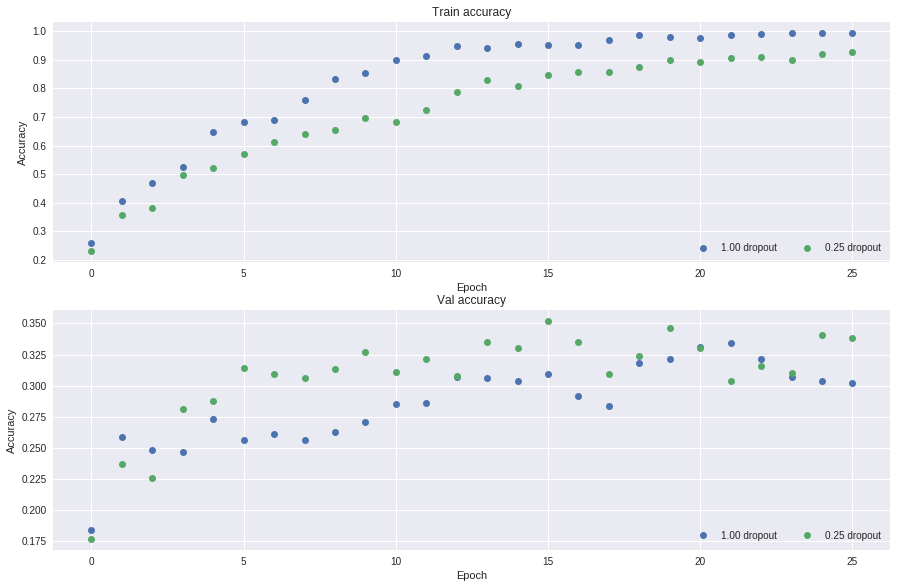

In [34]:
# Plot train and validation accuracies of the two models

train_accs = []
val_accs = []
for dropout in dropout_choices:
  solver = solvers[dropout]
  train_accs.append(solver.train_acc_history[-1])
  val_accs.append(solver.val_acc_history[-1])

plt.subplot(3, 1, 1)
for dropout in dropout_choices:
  plt.plot(solvers[dropout].train_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Train accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')
  
plt.subplot(3, 1, 2)
for dropout in dropout_choices:
  plt.plot(solvers[dropout].val_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.gcf().set_size_inches(15, 15)
plt.show()

## Inline Question 2:
Compare the validation and training accuracies with and without dropout -- what do your results suggest about dropout as a regularizer?

## Inline Question 3:
Suppose we are training a deep fully-connected network for image classification, with dropout after hidden layers (parameterized by keep probability p). How should we modify p, if at all, if we decide to decrease the size of the hidden layers (that is, the number of nodes in each layer)?